<h1>MALIS Lab Session 2 - Fall 2018</h1>

The aim of this lab is to practice with Support Vector Machines (SVM), and in particular with the PEGASOS (Primal Estimated sub-GrAdient SOlver for SVM) algorithm. PEGASOS is a fast stochastic sub-gradient descent algorithm for solving the primal optimization problem cast by an SVM. In the first part of this lab, you will be to implement PEGASOS. As it is based on a primal problem, it is only adapted to linear kernels; the authors of PEGASOS proposed a way to use other non-linear kernels, at the price of time efficiency. Therefore in the second part of the lab, instead of implementing that less efficient version of PEGASOS, you will work on a features mapping method that will allow you to separate non-linearly separable datasets using PEGASOS. You will test your implementations on four datasets.

Experiments should be made by groups of two students. Each group should produce a Jupyter Notebook with all their results and comments. We strongly encourage the addition of plots and visual representations to the report, bearing in mind that comments on graphical data are still necessary. Code for adding images to your notebook: ```<img src="path/to/image.png" />```.

Submit your complete notebook as an archive (tar -cf groupXnotebook.tar lab2/). Deadline for submitting your notebook: 21 December 2018.

<h2>Introduction</h2>
There are three parts to this lab session. 

1. A part on PEGASOS where you are asked to implement the stochastic version of PEGASOS;

2. A part on features mapping.

Data are 2D. You can visualize them by running the following cell (red dots are labeled -1 and green dots are labeled 1).

In [1]:
#Libraries 

from utils import print_dataset

<h4>Question 1</h4>
According to the above plots, do these datasets seem to be linearly separable? On which of these datasets do you expect a linear SVM to perform well? On which ones do you think it will perform badly?

<h4>Your answer</h4>


Dataset: data/dataset1.txt


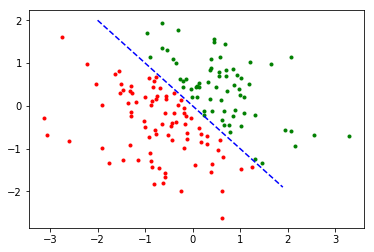

In [6]:
#Dataset 1
print_dataset("data/dataset1.txt")

The plot shown for dataset 1 shows two classes: class red (x) and class green (y). All green and red datapoints are mapped in space. A dataset is linearly seperable as soon as there is a clear line (depicted in blue) that can separate both sets x and y. If we would add new points to the set, we would be able to predict if a point belongs to x or y based on the point's position in space. Linear SVMs do not perform well on non-linearly seperable data without using the kernel trick. In order to make that work, we need to expand the linear kernel function. 

Dataset: data/dataset2.txt


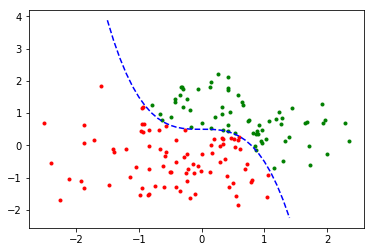

In [8]:
#Dataset 2
print_dataset("data/dataset2.txt")


This dataset is also sepreated in two classes: class red and green. However, it would not be easily seperated by a linear kernel. We could make it work, but the results would probably not make much sense. Rather, we should extend the linear Kernel function to a ploynomial kernel as shown by the blue line. By adding new variables to x and y (the predictor variables), it is possible to expand on the space which our data points are inside, making them easy to divide.

Dataset: data/dataset3.txt


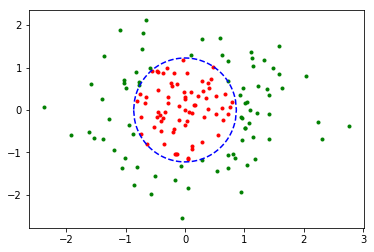

In [9]:
#dataset 3
print_dataset("data/dataset3.txt")


Dataset 3 is also no linearly seperable. Instead of a linear kernel, I would suggest using a radial basis kernel. Strictly speaking, the RBF kernel is also a linear kernel. What it actually does is to create non-linear combinations of the features to uplift the data points onto a higher-dimensional feature space where a linear seperator can easily be applied.

Dataset: data/dataset4.txt


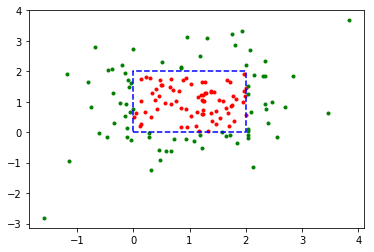

In [10]:
#dataset 4
print_dataset("data/dataset4.txt")

Dataset 4 is also no linearly seperable. Instead of a linear kernel, I would suggest using a radial basis kernel as well.

<h2>Part 1: PEGASOS</h2>

<h3>How PEGASOS works</h3>

<i>That sub-part gives some intuition about how PEGASOS can actually find the solution of a problem cast by a linear SVM. Reading it is not required to do the lab, but we encourage you to have a look at it as it may help you for your implementation.</i>

Let us assume that given a set $S = \lbrace (x_i, y_i) \rbrace$ where $x_i \in \mathbb{R}^n$ and $y_i \in \lbrace -1, 1 \rbrace$, we want to find a solution of the following problem

$$\min_{w, b} \frac{1}{2} \Vert w \Vert^2 + C \sum_i \max(0, 1-y_i(w^Tx_i + b))$$

where $C$ is a non-zero hyperparameter controlling the "softness" of the margin (the lower the $C$ the softer the margin), or equivalently

$$\min_{w, b} \frac{\lambda}{2} \Vert w \Vert^2 + \sum_i \max(0, 1-y_i(w^Tx_i + b))$$

where $\lambda$ replaces $C$ (the higher the $\lambda$ the softer the margin). We can get rid of the bias term $b$ by adding a constant feature to all the $x_i$ (we can assume without loss of generality that the value of the constant is 1) and by replacing $w$ by the concatenation of $w$ and $b$. In that setup, the optimization problem becomes (with $\tilde{w} = [w; b]$ and $\tilde{x_i} = [x_i; 1]$)

$$\min_{\tilde{w}} \frac{\lambda}{2} \Vert \tilde{w} \Vert^2 + \sum_i \max(0, 1-y_i(\tilde{w}^T\tilde{x_i})).$$

You can notice that the optimization problem we obtained is slightly different from the one we stated before, as $\Vert \tilde{w} \Vert^2$ should be replaced by $\Vert \tilde{w} \Vert^2 - b^2$. However, in practice, that difference has very few importance. Therefore in the following we will assume that $x_i \in \mathbb{R}^{n+1}$, $w \in \mathbb{R}^{n+1}$, and that the last feature of $x_i$ is always equal to 1. As we will work on the stochastic variant of PEGASOS, we will consider the following objective:

$$\min_{w_t} \frac{\lambda}{2} \Vert w_t \Vert^2 + \max(0, 1-y_{i_t}(w_t^Tx_{i_t}))$$

where $(x_{i_t}, y_{i_t})$ is a sample drawn randomly at iteration $t$ from $S$. The sub-gradient of the above objective is then given by:

$$\nabla w_t = \lambda w_t - \phi_I(x_{i_t}, y_{i_t}) y_{i_t}x_{i_t}$$

where $\phi_I$ is the indicator function of the set $I = \lbrace (x, y) \in R^d \times \lbrace -1, 1 \rbrace : y w^Tx < 1 \rbrace$ ($\phi_I(x, y) = 1$ if $(x, y) \in I$ and $\phi_I(x, y) = 0$ otherwise). Then, we compute $w_{t+1}$ using the following update formula:

$$w_{t+1} = w_t - \eta_t \nabla w_t$$

where $\eta_t = 1/(\lambda t)$. The algorithm stops after a predefined number of iterations. As you can understand, PEGASOS uses a stochastic gradient descent with learning rate $\eta_t$ to find the optimal parameters of an SVM. The next sub-part gives you a pseudo-code of PEGASOS. Your role will be to implement it based on that pseudo-code.

### Notes: 
 
$y_i.$ is the target (either 1 or -1)
We want to minimize the loss while maximizing the margin. The max term in kernel function accounts for the loss -> hinge loss. Min function accounts for the margin. We minimize the distance between data points and the margin and we maximize the number of correct classified points.
 
In Soft Margins, the Lambda term ( also C) is used to control our priorities. Changing it allows us to balance our emphasis on a large margin and our desire for correct classsification. If we decrease the value of lambda, we get our soft margin classifier to behave more like the hard margin classifier (less wiggle space) -> this will increase the amount of correctly classified samples at the cost of having a classifier which is less good at dealing with errors and the unexpected (the larger the margin, the better).
 
The purpose of stochastic gradient descent is to minimize the loss.







<img src="rsz_1024px-svm_margin.png" />

<h3>Pseudo-code of PEGASOS</h3>

Your task will now be to implement PEGASOS. An SVM class has been defined in utils.py. You are strongly encouraged to read it carefully to understand it.

<h4>Question 2</h4>
Complete the following implementation of PEGASOS.

<h4>Your answer</h4>

In [5]:
from utils import SVM
import numpy as np
def train_one_iteration(self, learning_rate, eta_t):
    '''
    Train for one epoch according to PEGASOS
    '''
    self.setnextinput() # Picks (x, y) in dataset uniformly at random
    if (self.gt*(np.dot(self.w, self.x))) < 1:
        new_w = self.w - eta_t*(learning_rate*self.w - self.gt*self.x) 
    else:
        new_w = self.w - eta_t *learning_rate*self.w
    self.w = new_w 
    
SVM.train_one_iteration = train_one_iteration


<h4>Question 3</h4>
Test your implementation on the four datasets (train your SVM during 1500 iterations with $\lambda = 0.0001$). Do you find the results that you forecast in Question 1?

<h4>Your answer</h4>

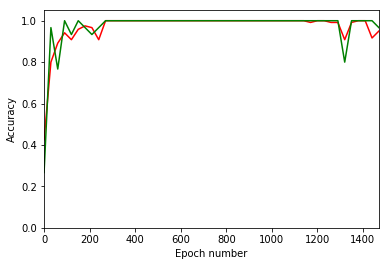

Accuracy: 93.33333333333333 %


In [6]:
from utils import Dataset

# Tests on dataset1
datafile = "data/dataset1_train.txt"
data = Dataset(datafile)
test_datafile = "data/dataset1_test.txt"
test_data = Dataset(test_datafile)

svm = SVM(data, test_data)
svm.train(1500, 0.0001)
svm.make_plot() # Train accuracy in red, test accuracy in green
svm.print_accuracy()

# Tests on other datasets
### IMPLEMENTATION REQUIRED ###

As expected, the Pegasos implementation does really well on linearly seperable data. We get an accuracy of over 90%, which is good. Reaults like this ensure us, that we are using the right Kernel. However, we would proabably want there to be more training data to make sure that we do not overfit. Cross Validation is also an option.

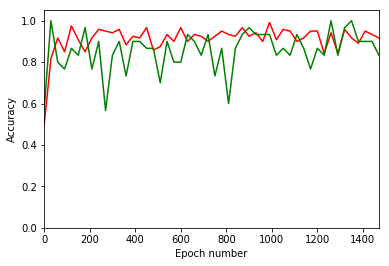

Accuracy: 83.33333333333334 %


In [7]:
datafile = "data/dataset2_train.txt"
data = Dataset(datafile)
test_datafile = "data/dataset2_test.txt"
test_data = Dataset(test_datafile)

svm = SVM(data, test_data)
svm.train(1500, 0.0001)
svm.make_plot() # Train accuracy in red, test accuracy in green
svm.print_accuracy()

Results are starting to decline as our data becomse more complex. The Pegasos still does a reasonably good job, but we can tell that we should investigate diffrent kernel functions to attain better results. 

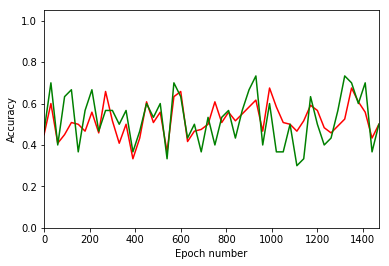

Accuracy: 43.333333333333336 %


In [8]:
datafile = "data/dataset3_train.txt"
data = Dataset(datafile)
test_datafile = "data/dataset3_test.txt"
test_data = Dataset(test_datafile)

svm = SVM(data, test_data)
svm.train(1500, 0.0001)
svm.make_plot() # Train accuracy in red, test accuracy in green
svm.print_accuracy()

Now, clearly the Pegasos is performing poorly. We barely reach an accuracy over 40%. Many points are misclassified.

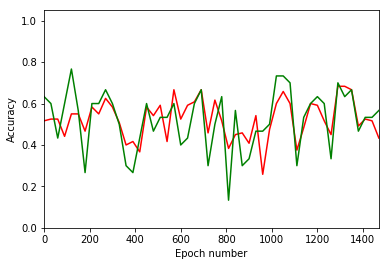

Accuracy: 36.666666666666664 %


In [9]:
datafile = "data/dataset4_train.txt"
data = Dataset(datafile)
test_datafile = "data/dataset4_test.txt"
test_data = Dataset(test_datafile)

svm = SVM(data, test_data)
svm.train(1500, 0.0001)
svm.make_plot() # Train accuracy in red, test accuracy in green
svm.print_accuracy()

Even more poorly, the linear SVM performs on dataset 4. We really don't get much out of using Pegasos on dataset3 and 4. 

<h2>Part 2: Features Maps</h2>

As you know, it is possible to use the "Kernel Trick" to separate non-linearly separable datasets with SVMs. This trick is meant to be applied on the dual problem. As PEGASOS is based on the primal problem, the Kernel Trick cannot be used easily with PEGASOS. However, there is a method to approximate the feature space corresponding to a given kernel. In this part, you will implement and test that method. You will not be asked to dig into the mathematical theory behind that method, but if you wish, you can find more informations in the paper <i>Random Features for Large-Scale Kernel Machines</i> by Ali Rahimi and Ben Recht [1].

<h2>Approximating the Radial Basis Function (RBF) kernel</h2>

The Radial Basis Function $K_\gamma$ is one of the most common kernels used with SVMs. It is defined as follows ($x, y \in \mathbb{R}^d$):

$$ K_\gamma(x, y) = \exp(-\gamma \Vert x - y \Vert^2).$$

Its feature space is of infinite dimension. However, you can approximate it according to the following algorithm (details in [1]):

The pseudo-code above transforms data from its original space to a new feature space approximating the feature space corresponding to the RBF kernel. You will now implement that pseudo-code.

#### About the RBF Kernel and why it outperforms the Linear Kernel

With the Kernel function, we define the function space, that we are working in. The squared exponential kernel (RBF) defines a very large function space. A lot larger than the linear kernel. In fact, the RBF kernel is even more powerful the polynomial functions. That is because:"An n-th order polynomial kernel gives you all analytic functions whose derivatives of order (n+1) are constant, and hence all derivatives of and above order (n+2) are zero. The squared exponential kernel gives you access to all analytic functions (that is all infinitely differentiable functions)".

The RBF kernel gives us a non-parametric kernel. Meaning, as we feed more and more data to our model, we are able to represent more and more complex realtionships. A parametric model in contrast will be saturaded at some point; it's model size is fixed and after some point giving it more data won't help.

Source: https://www.quora.com/Why-does-RBF-kernel-generally-outperforms-linear-or-polynomial-kernels

<h4>Question 4</h4>
Complete the following implementation of the FeaturesMap class.

<h4>Your answer</h4>

In [14]:
import numpy as np
from utils import Dataset, PI
from math import cos
import random

class FeaturesMap:
    
    w = []
    x = []
    def __init__(self, dim, old_dim, gamma):
        mean = np.zeros(old_dim)
        cov = 2*old_dim*gamma*np.eye(old_dim)
        self.dim = dim
        self.omega = [np.random.multivariate_normal(mean, cov) for _ in range(dim)]
        self.b = [random.random()*2*PI for _ in range(dim)]

    def __call__(self, dataset):
        outputs = dataset.output
        inputs = []
        for x in dataset.input:
            new_feats = []
            for i in range(self.dim):
                feat = np.cos(np.dot(self.omega[i],x)+self.b[i])
                new_feats.append(feat)
            new_feats = np.array(new_feats)
            new_feats *= np.sqrt(2/self.dim)
            inputs.append(new_feats)
        new_data = Dataset(input_size=self.dim, length=dataset.len)
        new_data.input = inputs
        new_data.output = outputs
        return new_data

<h4>Question 5</h4>
Test your implementation on the four artificial datasets. Train your SVM during 1500 iterations with $\lambda = 0.0001$. The dimension of the feature space is 200 and $\gamma = 1$. How do your results change with respect to what you found in Question 3?

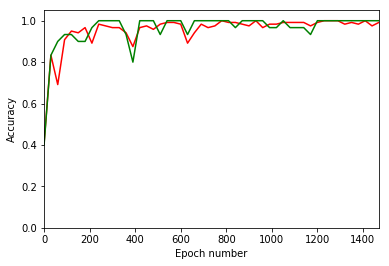

Accuracy: 100.0 %


In [15]:
from utils import Dataset

# Tests on dataset1
datafile = "data/dataset1_train.txt"
data = Dataset(datafile)
test_datafile = "data/dataset1_test.txt"
test_data = Dataset(test_datafile)

features_map = FeaturesMap(200, 2, 1)
new_data = features_map(data)
new_test_data = features_map(test_data)

svm = SVM(new_data, new_test_data)
svm.train(1500, 0.0001)
svm.make_plot() # Train accuracy in red, test accuracy in green
svm.print_accuracy()

# Tests on other datasets
### IMPLEMENTATION REQUIRED ###

The RBF kernel scores a perfect 100% on dataset 1. Even though the dataset is linearly seperable, the linear kernel could not attain a 100% accuracy. The RBF Kernel does so well, because it is able to take advantage of that rich function space. However, the RBF model is very sensible to gamma. Which will be seen next.

<h2>The role of $\gamma$ in the RBF kernel</h2>

<h4>Question 6</h4>
Do the same tests with $\gamma = 10^{-6}$. What do you notice? How can you explain your results?

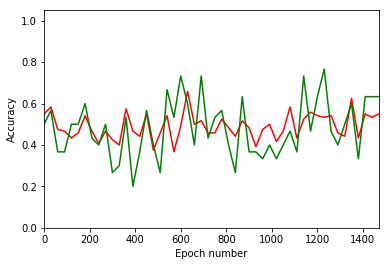

Accuracy: 43.333333333333336 %


In [17]:
from utils import Dataset

# Tests on dataset1
datafile = "data/dataset1_train.txt"
data = Dataset(datafile)
test_datafile = "data/dataset1_test.txt"
test_data = Dataset(test_datafile)

features_map = FeaturesMap(200, 2, 1e-6)
new_data = features_map(data)
new_test_data = features_map(test_data)

svm = SVM(new_data, new_test_data)
svm.train(1500, 0.0001)
svm.make_plot() # Train accuracy in red, test accuracy in green
svm.print_accuracy()

# Tests on other datasets
### IMPLEMENTATION REQUIRED ###

Gamma is the parameter that controls the "rising" of datapoints in a higher space. More specifically, it controls for the peaks where the points are raised. A higher gamma yields a smaller spike, while a lower gamma yields a softer, broader spike. A low gamma allows for the capturing of more complexity, and shape of the data, but if the value of gamma is too large, then the model can overfit and be prone to low bias/high variance. If the value gamma is too small, the support vector will not have much influence on the classifications of the points.Thus, the poor results for the algorithm depicted above. 

<h4>Question 7</h4>
Do the same tests with $\gamma = 10^{4}$. What do you notice? How can you explain your results?

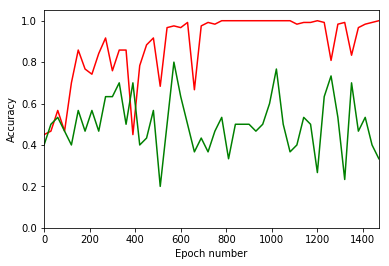

Accuracy: 50.0 %


In [18]:
from utils import Dataset

# Tests on dataset1
datafile = "data/dataset1_train.txt"
data = Dataset(datafile)
test_datafile = "data/dataset1_test.txt"
test_data = Dataset(test_datafile)

features_map = FeaturesMap(200, 2, 1e4)
new_data = features_map(data)
new_test_data = features_map(test_data)

svm = SVM(new_data, new_test_data)
svm.train(1500, 0.0001)
svm.make_plot() # Train accuracy in red, test accuracy in green
svm.print_accuracy()

# Tests on other datasets
### IMPLEMENTATION REQUIRED ###

The algorithm above depicts the case of overfitting. Gamma is too large, which again lead to poor results. More can be found here: https://www.quora.com/What-are-C-and-gamma-with-regards-to-a-support-vector-machine